# Tema 8: Hadamard Test

Curso ICC02.

Autor: Alejandro Mata Ali

En este notebook vamos a implementar el Hadamard Test para diferentes operadores.

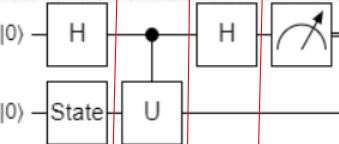

## Librerías

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import MCMT, ZGate, XGate, YGate
import numpy as np

---
# Circuito cuántico

Para el circuito cuántico tendremos que tener n qubits objetivo y un qubit ancilla. Vamos a definirlo ya de forma abstracta con una función que reciba el número n, el estado cuántico y el operador U. Además, le pondremos un parámetro de entrada para escoger si queremos la parte real o la parte imaginaria.

In [2]:
def Hadamard_Circuit(n:int, state, U, Re: bool=True):
    #Registros
    anc = QuantumRegister(1, 'ancilla')
    qr = QuantumRegister(n, 'q')
    cr = ClassicalRegister(1, 'c')

    #Circuito
    qc = QuantumCircuit(anc, qr, cr, name='Hadamard')

    #H en la ancilla
    qc.h(anc[0])

    #Inicializamos el estado, también podemos usar StatePreparation
    qc.initialize(state, qubits=qr[:], normalize=True)

    #Control-U (otra forma de definirlo)
    controlU = U.control(1)
    qc.append(controlU, range(n+1))
    qc.barrier()

    #Para la parte imaginaria
    if Re == False:
        qc.sdg(anc[0])

    #H en ancilla
    qc.h(anc[0])

    #Mediciones
    qc.measure(anc[0],0)

    #Esto es por visualización
    decomp_qc = qc.decompose(['State_Preparation', 'c_U', 'U'], reps=1)

    return decomp_qc

Ahora definamos un operador para introducir.  Vamos a probar uno usualmente utilizado:
$$U = \mathbb{I}\otimes Z\otimes\mathbb{I}$$

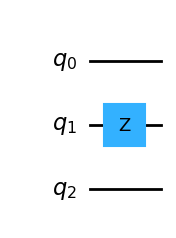

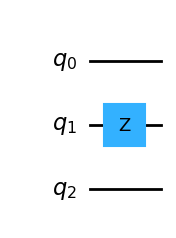

In [3]:
n = 3

#Registros
qr = QuantumRegister(n, 'q')

U = QuantumCircuit(qr, name='U')

#Puertas
U.z(1)

U.draw('mpl')

Convertimos el U en una gate.

In [4]:
U_gate = U.to_gate()

Creamos un circuito cuántico de esos n qubits.

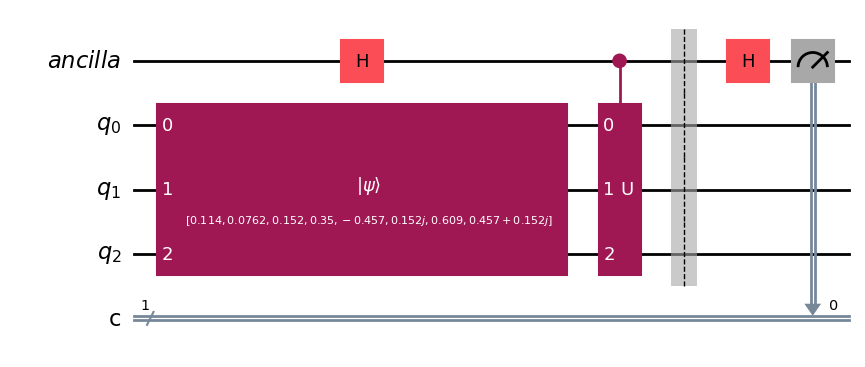

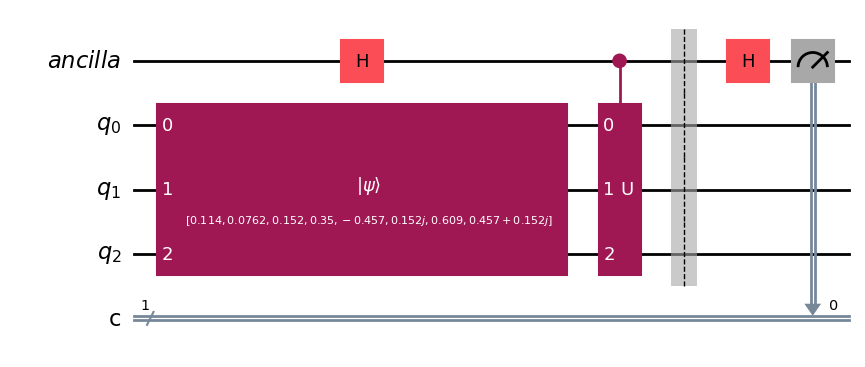

In [5]:
#Vector de estado
state = np.array([0.75, 0.5, 1, 2.3, -3, 1j, 4, 3+1j])
state /= np.sqrt(sum(state*np.conjugate(state)))

qcRe = Hadamard_Circuit(n, state, U)

qcRe.draw('mpl')

### Ejercicio

Prueba a buscar la componente imaginaria y llámalo qcIm.

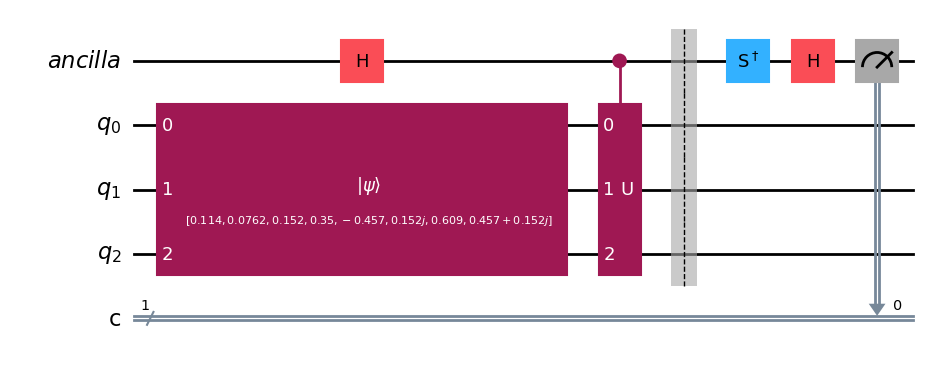

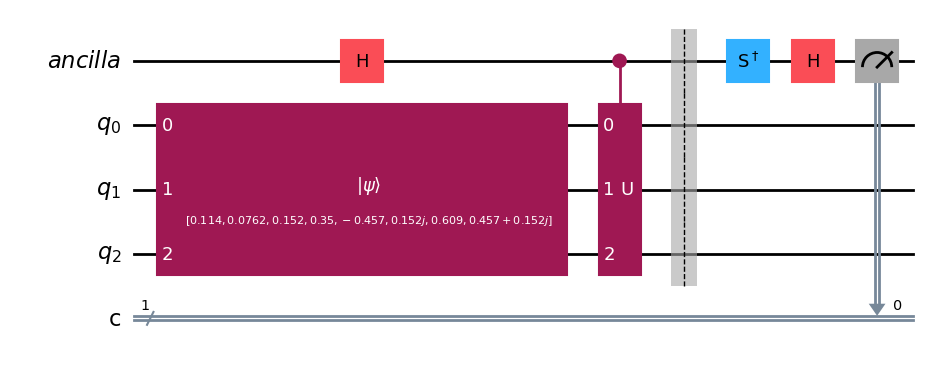

In [6]:
#Vector de estado
state = np.array([0.75, 0.5, 1, 2.3, -3, 1j, 4, 3+1j])
state /= np.sqrt(sum(state*np.conjugate(state)))

qcIm = Hadamard_Circuit(n, state, U, Re=False)

qcIm.draw('mpl')

---
# Ejecutando el circuito

Ejecutamos el circuito en simulador.

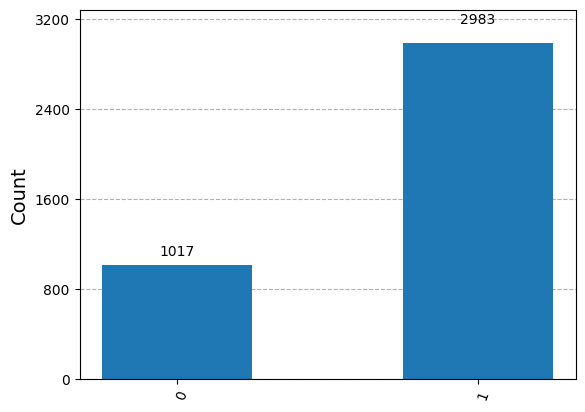

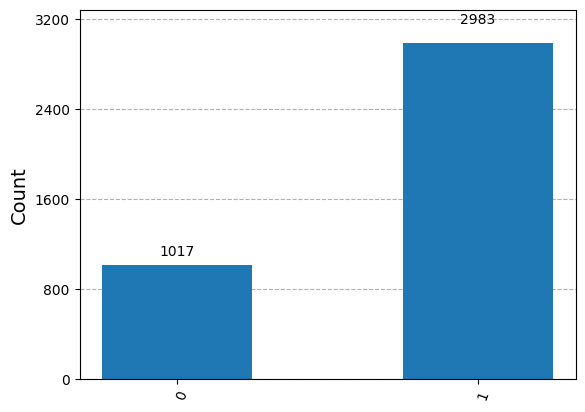

In [7]:
#Simulador de n+1 qubits
backend = GenericBackendV2(num_qubits=n+1)

#Transpilamos
qc_transpiled = transpile(qcRe, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=4000)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Vamos a calcular la parte real del valor esperado como

$$Re(\langle U \rangle) = 2P(0)-1$$


In [8]:
Re_U = 2* ( counts['0']/(counts['0']+counts['1'] )) - 1
Re_U

-0.49150000000000005

Ahora la parte imaginaria.

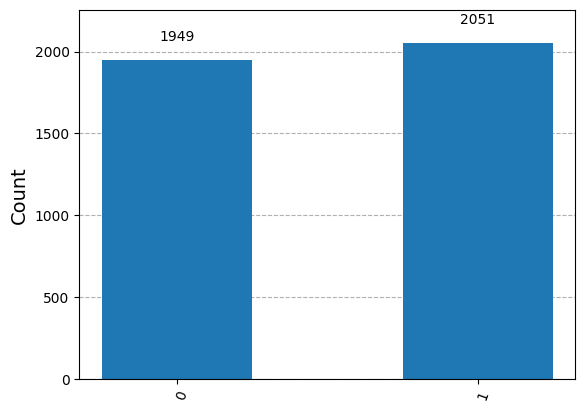

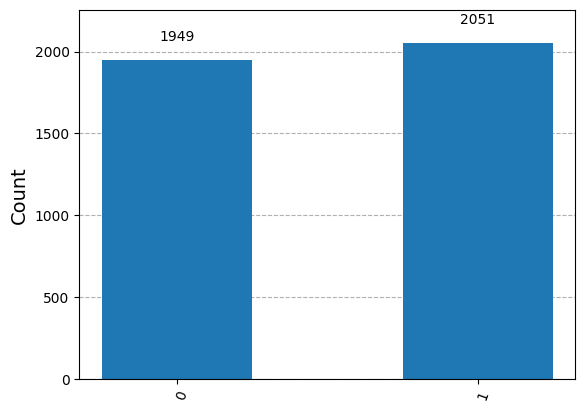

In [9]:
qc_transpiled = transpile(qcIm, backend)

#Creamos el job
job = backend.run(qc_transpiled, shots=4000)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

In [10]:
Im_U = 2* ( counts['0']/(counts['0']+counts['1'] )) - 1
Im_U

-0.025499999999999967

Clásicamente sería

In [11]:
I = np.eye(2)
Z = np.array([[1,0],[0,-1]])

U = np.kron(np.kron(I,Z),I)

print('Cuántico: ', Re_U+Im_U*1j)
print('Exacto:   ', np.conjugate(state) @ U @ state)

Cuántico:  (-0.49150000000000005-0.025499999999999967j)
Exacto:    (-0.4982889623571719+0j)


Vemos que es consistente, aunque con un pequeño error debido al número limitado de shots.

---
# Prueba con otro operador

Ahora haz un circuito para otro estado y operador y pruébalo con diferente número de shots para ver la precisión.

In [12]:
n = 3

#Registros
qr = QuantumRegister(n, 'q')

U = QuantumCircuit(qr, name='U')

#Puertas
U.s(1)

U_gate = U.to_gate()

#Vector de estado
state = np.array([0.75+0.1j, 0.5-0.2j, 1-1j, 2.3+0.25j, -3-0.43j, 1j-0.4j, 4+2j, 3+1j])
state /= np.sqrt(sum(state*np.conjugate(state)))

qcRe = Hadamard_Circuit(n, state, U)
qcIm = Hadamard_Circuit(n, state, U, False)

backend = GenericBackendV2(num_qubits=n+1)

#Parte real
qc_transpiled = transpile(qcRe, backend)

#Creamos el job
job = backend.run(qc_transpiled, shots=4000)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()

Re_U = 2* ( counts['0']/(counts['0']+counts['1'] )) - 1

#Parte imaginaria
qc_transpiled = transpile(qcIm, backend)

#Creamos el job
job = backend.run(qc_transpiled, shots=4000)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()

Im_U = 2* ( counts['0']/(counts['0']+counts['1'] )) - 1

#Clásico
I = np.eye(2)
S = np.array([[1,0],[0,1j]])

U_matriz = np.kron(np.kron(I,S),I)

print('Cuántico: ', Re_U+1j*Im_U)
print('Exacto:   ', np.conjugate(state) @ U_matriz @ state)

Cuántico:  (0.22150000000000003+0.7470000000000001j)
Exacto:    (0.21791084152186246+0.7820891584781373j)


A más shots, mayor precisión.